In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font',**{'family':'sans-serif',
             'sans-serif':['Arial'],
             'size':12})
rc('pdf', fonttype=42)
rc('ps', fonttype=42)

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
p_root_dir = Path.cwd().parents[1]
p_data = p_root_dir / "5_data"

# Classification
p_chem_class = p_data / r"custom_classification/custom_classification_v2.csv"

# Predictions
p_predictions = p_data / "Interlab_data_19Apr2023.csv"
source = p_predictions.stem

In [3]:
# Load predictions and format neutral loss column
df = pd.read_csv(p_predictions)
df.neutral_loss.fillna('', inplace=True)

# Only consider data of detected ions
threshold = 0.8
df['detectability'] = df.pred_val >= threshold
data = df[df.detectability]

In [4]:
# Sum intensities of detected ions per metabolite in each sample
data['sum_intensity_per_metabolite'] = data.groupby(["Sample name", "name_short"])["spot_intensity_bgr_corrected"].transform('sum')

# Calculate the fractions of detected ion intensities per metabolite in each sample
data['fraction_per_ion'] = data.spot_intensity_bgr_corrected / data.sum_intensity_per_metabolite

<ipython-input-4-52d6c918a8ad>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['sum_intensity_per_metabolite'] = data.groupby(["Sample name", "name_short"])["spot_intensity_bgr_corrected"].transform('sum')
<ipython-input-4-52d6c918a8ad>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['fraction_per_ion'] = data.spot_intensity_bgr_corrected / data.sum_intensity_per_metabolite


## Calculate averages per class

In [5]:
#Format series formulas to publicatseries standard
def pretty_ion_formulas(data, colname):
       
    new_series = data[colname].copy()
    new_series = new_series.str.replace(r"[M]-", "", regex=False)
    new_series = new_series.str.replace(r"[M]+", "", regex=False)
    new_series = new_series.str.replace("([0-9])","$_\\1$", regex=True)
    new_series = [f"[M{s}]" if s != "Other" else s for s in new_series]
        
    newdata = data.copy() 
    newdata[colname] = new_series
    
    # Add ion charge in superscript accordint to the polarity
    newdata.loc[newdata.Polarity == "positive", colname].apply(lambda s: f"{s}$^+$'")
    newdata.loc[newdata.Polarity == "positive", colname].apply(lambda s: f"{s}$^-$'")
    
    for i, r in newdata.iterrows():
        polarity = r.Polarity
        s = r[colname]
        if s!="Other":
            if polarity == 'positive':
                newdata.loc[i, colname] = f"{s}$^+$"
            else:
                newdata.loc[i, colname] = f"{s}$^-$"
    return newdata

def prepare_data_for_plotting(data, custom_col_order=None):
    # transform data into plotting-compatible format
    plot_data = data.pivot(index="main_coarse_class",
              columns="main_ion_type",
              values="fraction_per_ion")

    if custom_col_order==None:
        # Sort columns from largest to smallest
        custom_col_order = plot_data.sum().sort_values(ascending=False).index.values
        # Move "Other" to the end
        custom_col_order = np.delete(custom_col_order, np.argwhere(custom_col_order == "Other"))
        custom_col_order = np.append(custom_col_order, "Other")
        
    # Change the dataframe accordingly
    plot_data.columns=pd.CategoricalIndex(plot_data.columns.values, ordered=True, 
                                   categories=custom_col_order)
    plot_data = plot_data.sort_index(axis=1)
    return plot_data

def plot_signal_composition(data):
    ax = data.plot.barh(rot=0, stacked=True)

    # Plot appearance
    ax.invert_yaxis()
    ax.set_xlabel('Fraction')
    ax.set_ylabel('')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Legend appearance
    ax.legend(loc="upper left", bbox_to_anchor=(1,1), frameon=False)
    return ax

In [6]:
# Load classification and map to the data
classes = pd.read_csv(p_chem_class, index_col='internal_id')[['name_short', 'main_coarse_class']].drop_duplicates()
mapped_data = data.merge(classes, on='name_short', how='left')

# Rename all matrix neutral gains into one category 'Matrix'
matrix_neutral_gain = ['+C10H10N2', '+C10H6ClNO2','+C10H7NO3', '+C10H8N2','+C11H8N2','+C12H14N2',
                       '+C13H10N2', '+C18H18N2O3','+C6H6N2O2','+C7H4ClNS2','+C7H6O4', '+C8H8O3']
mapped_data['neutral_loss'] = mapped_data['neutral_loss'].apply(lambda x: '+Matrix' if x in matrix_neutral_gain else x)

# Add new column
mapped_data['ion_type'] = mapped_data.adduct + mapped_data.neutral_loss

# Edit ion formulas
mapped_data = pretty_ion_formulas(mapped_data, "ion_type")

In [7]:
# Zero-fill
zero_filled_data = mapped_data.pivot_table(index=['Sample name', 'Technology', 'Polarity', 'main_coarse_class', 'name_short'],
                                      columns=['ion_type'],
                                      values=['fraction_per_ion'],
                                      aggfunc='sum', # this line only needed for metabolites that had 2 detected neutral gains with DAN matrix
                                      fill_value=0).stack(level=1)

In [8]:
# Calculate average values per ion in each class and sample
averages = zero_filled_data.pivot_table(index=['Sample name', 'Technology', 'Polarity', 'main_coarse_class', 'ion_type'],
                 values=['fraction_per_ion'],
                 aggfunc={'fraction_per_ion':'mean'}).reset_index()

### Calculate average ion abundances in each polarity across all datasets
- Panel with both polarities for the main figure

In [9]:
# Average per-calculated Sample data
global_data = averages.pivot_table(index=['Polarity', 'main_coarse_class', 'ion_type'],
                 values=['fraction_per_ion'],
                 aggfunc={'fraction_per_ion':'mean'}).reset_index()

# Combine low fractions into one category "Other"
global_data['main_ion_type'] = global_data.ion_type
threshold = 0.05 # Combine all ions that are individually less intense than 5% total deected intensity
global_data.loc[global_data.fraction_per_ion < threshold, "main_ion_type"] = "Other"

global_data = global_data.groupby(['Polarity', 'main_coarse_class', 'main_ion_type']).agg('sum').reset_index()

<ipython-input-9-1ad33c97b6bc>:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  global_data = global_data.groupby(['Polarity', 'main_coarse_class', 'main_ion_type']).agg('sum').reset_index()


In [10]:
# print("Sanity check")
# global_data.groupby(['Polarity', 'main_coarse_class']).agg('sum')

# # Make a test plot for one technolgy
# test = global_data[(global_data.Polarity=="positive")]

# plot_data = prepare_data_for_plotting(test)
# plot_signal_composition(plot_data)

### Calculate average ion abundances per each technology in each polarity
- Panels for all technologies for Sup. Info
- Panel with 3 examples

In [11]:
# Average per-calculated Sample data
technology_data = averages.pivot_table(index=['Technology', 'Polarity', 'main_coarse_class', 'ion_type'],
                 values=['fraction_per_ion'],
                 aggfunc={'fraction_per_ion':'mean'}).reset_index()

# Combine low fractions into one category "Other"
technology_data['main_ion_type'] = technology_data.ion_type
threshold = 0.05 # Combine all ions that are individually less intense than 5% total deected intensity
technology_data.loc[technology_data.fraction_per_ion < threshold, "main_ion_type"] = "Other"

technology_data = technology_data.groupby(['Technology', 'Polarity', 'main_coarse_class', 'main_ion_type']).agg('sum').reset_index()

<ipython-input-11-da13b6926ae0>:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  technology_data = technology_data.groupby(['Technology', 'Polarity', 'main_coarse_class', 'main_ion_type']).agg('sum').reset_index()


In [12]:
# # Make a test plot for one technolgy
# test = technology_data[(technology_data.Polarity=="positive")&(technology_data["Technology"]=='AP-MALDI-Orbitrap')]

# print("Sanity check")
# test.groupby(['Technology', 'Polarity', 'main_coarse_class']).agg('sum')

# plot_data = prepare_data_for_plotting(test)
# plot_signal_composition(plot_data)

### Make plots for paper

In [13]:
paul_tol = ['#E8ECFB', '#D9CCE3', '#D1BBD7', '#CAACCB', '#BA8DB4', '#AE76A3', 
            '#AA6F9E', '#994F88', '#882E72', '#1965B0', '#437DBF', '#5289C7', 
            '#6195CF', '#7BAFDE', '#4EB265', '#90C987', '#CAE0AB', '#F7F056', 
            '#F7CB45', '#F6C141', '#F4A736', '#F1932D', '#EE8026', '#E8601C', 
            '#E65518', '#DC050C', '#A5170E', '#72190E', '#42150A', '#777777', '#ffffff']

In [14]:
p_out = p_root_dir / r"6_figures\figure_5\signal_dilution\averages"

#### Establish colours for main figures

In [15]:
# Colours should be consistent between all panels, so check how many colours are needed

technology_subset = technology_data[(technology_data.Polarity=='positive')&\
                                   (technology_data.Technology.isin(['AP-MALDI-Orbitrap', 'DESI-Orbitrap', 'IR-MALDESI-Orbitrap']))
                                   ]

terms = pd.concat([global_data, technology_subset])[['Polarity', 'main_ion_type']].drop_duplicates()
terms.groupby('Polarity').count()-2 # white and grey,

,main_ion_type
Polarity,
negative,7
positive,12


#### Main panel with global averages per polarity

In [16]:
# global pos
custom_order_pos = [
'[M]$^+$',
'[M+H]$^+$', 
'[M+Na]$^+$', 
'[M+H-H$_2$O]$^+$',
'[M+H-NH$_3$]$^+$', 
'[M+H-H$_2$]$^+$',
'[M+H$_2$]$^+$',
'[M+Na+Matrix]$^+$',
'Other']

color_dict_pos = { # this is in agreement with colour mapping for all technologies
'[M+H]$^+$':15, 
'[M+Na]$^+$':17, 
'[M]$^+$':9,
'[M+H-H$_2$O]$^+$':18,
'[M+H-NH$_3$]$^+$':6, 
'[M+H-H$_2$]$^+$':10,
'[M+H$_2$]$^+$':26,
'[M+Na+Matrix]$^+$':30, #grey
'Other': 31, #white
'[M+K]$^+$':21,
'[M+H-CH$_2$O$_3$]$^+$':12,
'[M+K-CH$_2$O$_3$]$^+$':24, 
'[M+Na-HPO$_3$]$^+$':3,
'[M+Na-H$_2$]$^+$':14}

colors_pos = [paul_tol[v-1] for k,v in color_dict_pos.items()]
color_dict_pos = dict(zip(color_dict_pos, colors_pos))

In [17]:
# global_neg
custom_order_neg = [
'[M]$^-$',
'[M-H]$^-$',
'[M+Cl]$^-$', 
'[M-H-H$_2$O]$^-$',
'[M-H-CO$_2$]$^-$',
'[M-H-HPO$_3$]$^-$', 
'[M-H+H$_2$]$^-$',
'[M-H+Matrix]$^-$', 
'Other']
    
#global_neg
color_dict_neg = {
'[M-H]$^-$':'#77AADD',
'[M+Cl]$^-$':'#99DDFF', 
'[M]$^-$':'#EE8866', 
'[M-H-H$_2$O]$^-$':'#BBCC33', 
'[M-H-CO$_2$]$^-$':'#EEDD88', 
'[M-H-HPO$_3$]$^-$':'#44BB99', 
'[M-H+H$_2$]$^-$':'#FFAABB', 
'[M-H+Matrix]$^-$':'#777777',
'Other': "#FFFFFF" #white
}

<ipython-input-18-76ff9cd7bb34>:29: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


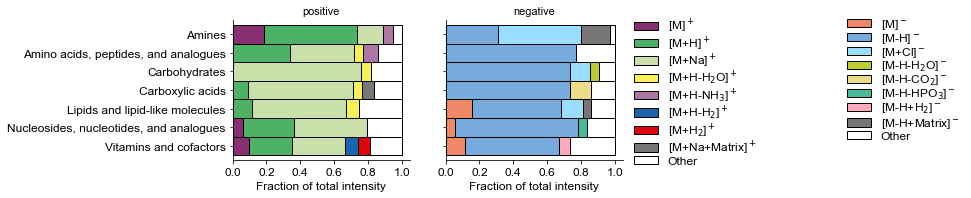

In [18]:
title = "average_per_polarity"

fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(7, 4))

for ax, polarity, order, color_dict in zip(axs.ravel(), 
                               ['positive', 'negative'],
                               [custom_order_pos, custom_order_neg],
                               [color_dict_pos, color_dict_neg]
                              ):
    subset = global_data[global_data.Polarity==polarity]

    # Prepeare data for plotting
    plot_data = prepare_data_for_plotting(subset, order)    
    custom_palette = [color_dict.get(x) for x in plot_data.columns]

    # Make a plot
    plot_data.plot(kind="barh", rot=0, stacked=True, color=custom_palette, edgecolor='k', ax=ax, width=1)
    ax.invert_yaxis()
    ax.set_title(polarity, fontsize=11)
    ax.set_xlabel('Fraction of total intensity')
    ax.set_ylabel('')
    ax.set_xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_aspect(adjustable='box', aspect=0.11)

    # Legend appearance
    ax.legend(loc="upper left", bbox_to_anchor=(2.2,1.1), frameon=False, ncol=1, labelspacing=0)    
fig.tight_layout()
fig.savefig(p_out / f"{title}.png")
fig.savefig(p_out / f"{title}.pdf", transparent=True)

#### Main panel with 3 example technologies

In [19]:
custom_col_order = [
'[M]$^+$',
'[M+H]$^+$', 
'[M+Na]$^+$',
'[M+K]$^+$',
'[M+H-H$_2$O]$^+$',
'[M+H-NH$_3$]$^+$',
'[M+H-CH$_2$O$_3$]$^+$',
'[M+K-CH$_2$O$_3$]$^+$', 
'[M+Na-HPO$_3$]$^+$',
'[M+H-H$_2$]$^+$',
'[M+Na-H$_2$]$^+$',
'[M+H$_2$]$^+$',
'[M+Na+Matrix]$^+$',
'Other']

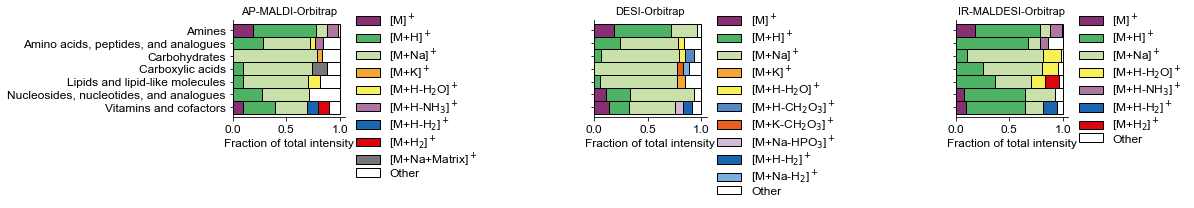

In [20]:
title = "technology_examples"

fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(18,2.5))

for ax, technology in zip(axs.ravel(), technology_subset.Technology.unique()):
    subset = technology_subset[technology_subset.Technology == technology]
    
    # Prepeare data for plotting
    plot_data = prepare_data_for_plotting(subset, custom_col_order)    
    custom_palette = [color_dict_pos.get(x) for x in plot_data.columns]

    # Make a plot
    plot_data.plot(kind="barh", rot=0, stacked=True, color=custom_palette, ax=ax, edgecolor='k', width=1)
    ax.invert_yaxis()
    ax.set_title(technology, fontsize=11)
    ax.set_xlabel('Fraction of total intensity')
    ax.set_ylabel('')
    ax.set_xticks([0, 0.5, 1])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_aspect(adjustable='box', aspect=0.12)

    # Legend appearance
    ax.legend(loc="upper left", bbox_to_anchor=(1,1.2), frameon=False, ncol=1, labelspacing=0) 

fig.tight_layout()
fig.savefig(p_out / f"{title}.png")
fig.savefig(p_out / f"{title}.pdf", transparent=True)

#### Supplementary panel with all technologies

In [21]:
p_out = p_root_dir / r"6_figures\figure_5\signal_dilution\Supplementary"

In [22]:
# Colours should be consistent between all panels, so check how many colours are needed

terms = technology_data[['Polarity', 'main_ion_type']].drop_duplicates()
terms.groupby('Polarity').count()-2 # white and grey

,main_ion_type
Polarity,
negative,12
positive,18


- Positive plots
- Legend colours are the same, but I just print it next to each subplot because with so many categories it can be difficult otherwise

In [23]:
# Here one of the easy ways to do this was to assign colours manually

color_dict_pos = {
'[M+Na]$^+$':17, 
'[M+H]$^+$':15, 
'[M+H-H$_2$O]$^+$':18, 
'[M]$^+$':9,
'[M+H-NH$_3$]$^+$':6, 
'[M+H$_2$]$^+$':26, 
'[M+K]$^+$':21, 
'[M+Na+Matrix]$^+$':30, #grey
'[M+H-H$_2$]$^+$':10, 
'[M+Matrix]$^+$':28, 
'[M+Na-HPO$_3$]$^+$':3,
'[M+Na+H$_2$]$^+$':5,
'[M+H+Matrix]$^+$':16,
'[M+H-CO$_2$]$^+$':27,
'[M+H-HPO$_3$]$^+$':22, 
'[M+H-CH$_2$O$_3$]$^+$':12, 
'[M+Na-H$_2$O]$^+$':7,
'[M+Na-H$_2$]$^+$':14, 
'[M+K-CH$_2$O$_3$]$^+$':24,
 'Other': 31 #white
}

colors = [paul_tol[v-1] for k,v in color_dict_pos.items()]
color_dict = dict(zip(color_dict_pos, colors))

In [24]:
custom_col_order = ['[M]$^+$', '[M+Na]$^+$', '[M+H]$^+$', '[M+K]$^+$',  
                    '[M+H-H$_2$O]$^+$', '[M+Na-H$_2$O]$^+$',
                    '[M+H-NH$_3$]$^+$',
                    '[M+H-CO$_2$]$^+$',
                    '[M+H-HPO$_3$]$^+$',
                    '[M+Na-HPO$_3$]$^+$',
                    '[M+H-CH$_2$O$_3$]$^+$',
                    '[M+K-CH$_2$O$_3$]$^+$', 
                    '[M+H$_2$]$^+$', 
                    '[M+Na+H$_2$]$^+$', 
                    '[M+H-H$_2$]$^+$', 
                    '[M+Na-H$_2$]$^+$',                       
                    '[M+Matrix]$^+$', '[M+H+Matrix]$^+$', '[M+Na+Matrix]$^+$',
                    'Other']

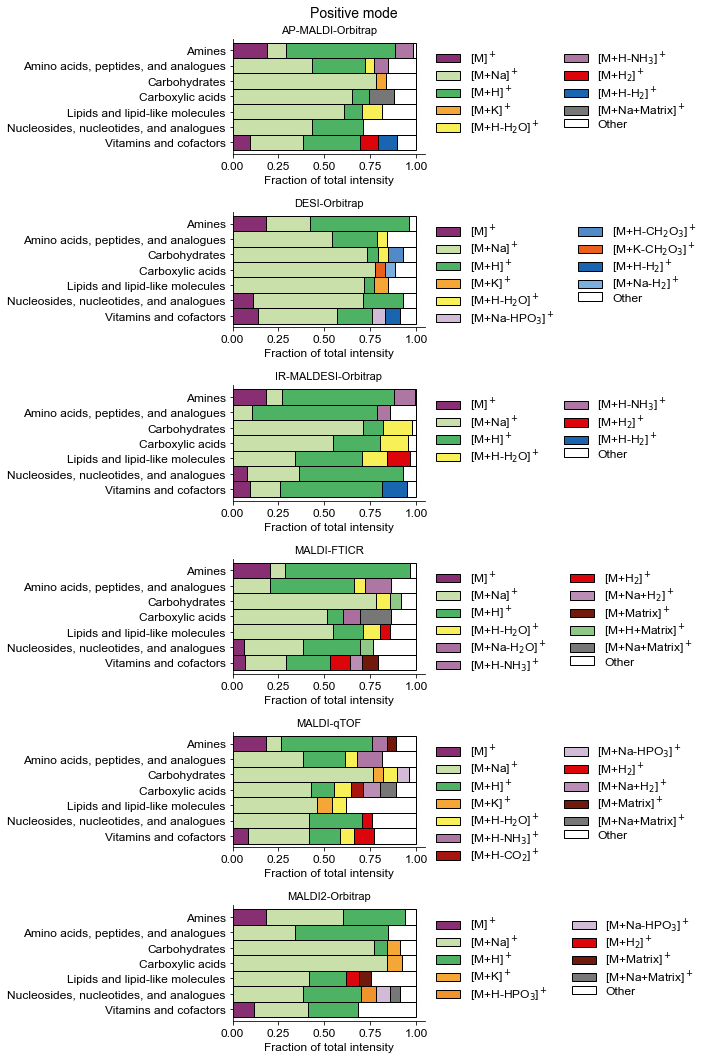

In [25]:
input_data = technology_data[technology_data.Polarity=="positive"]
title = "signal_dilution_per_techbnology_positive"

fig, axs = plt.subplots(nrows=6, ncols=1, sharey=True, figsize=(10,15))

for ax, technology in zip(axs.ravel(), input_data.Technology.unique()):
    subset = input_data[input_data.Technology == technology]
    
    # Prepeare data for plotting
    plot_data = prepare_data_for_plotting(subset, custom_col_order)    
    custom_palette = [color_dict.get(x) for x in plot_data.columns]

    # Make a plot
    plot_data.plot(kind="barh", rot=0, stacked=True, color=custom_palette, ax=ax, edgecolor='k', width=1)
    ax.invert_yaxis()
    ax.set_title(technology, fontsize=11)
    ax.set_xlabel('Fraction of total intensity')
    ax.set_ylabel('')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Legend appearance
    ax.legend(loc="upper left", bbox_to_anchor=(1,1), frameon=False, ncol=2, labelspacing=0)  
    
fig.suptitle('Positive mode', fontsize=14)
fig.tight_layout()
fig.savefig(p_out / f"{title}.png")
fig.savefig(p_out / f"{title}.pdf", transparent=True)

- Negative mode

In [26]:
# Here one of the easy ways to do this was to assign colours manually
paul_tol = ['#E8ECFB', '#D9CCE3', '#D1BBD7', '#CAACCB', '#BA8DB4', '#AE76A3', 
            '#AA6F9E', '#994F88', '#882E72', '#1965B0', '#437DBF', '#5289C7', 
            '#6195CF', '#7BAFDE', '#4EB265', '#90C987', '#CAE0AB', '#F7F056', 
            '#F7CB45', '#F6C141', '#F4A736', '#F1932D', '#EE8026', '#E8601C', 
            '#E65518', '#DC050C', '#A5170E', '#72190E', '#42150A', '#777777', '#ffffff']


color_dict_neg = {
'[M-H]$^-$':10, 
'[M+Cl]$^-$':26, 
'[M]$^-$':18, 
'[M-H+Matrix]$^-$':15,
'[M-H-CO$_2$]$^-$':14, 
'[M-H+H$_2$]$^-$':17, 
'[M-H-H$_2$O]$^-$':9,
'[M-H-HPO$_3$]$^-$':21, 
'[M-H$_2$]$^-$':24, 
'[M+Matrix]$^-$':30, #grey,
'[M-H-H$_2$]$^-$':12, 
'[M-H-NH$_3$]$^-$':3, 
'[M-HPO$_3$]$^-$':6,
'Other': 31 # white
}

colors = [paul_tol[v-1] for k,v in color_dict_neg.items()]
color_dict = dict(zip(color_dict_neg, colors))

In [27]:
custom_col_order = [
'[M-H]$^-$', '[M+Cl]$^-$', '[M]$^-$', 
'[M-H-H$_2$O]$^-$',
'[M-H-NH$_3$]$^-$',
'[M-H-CO$_2$]$^-$',  
'[M-H-HPO$_3$]$^-$', 
'[M-HPO$_3$]$^-$',
'[M-H+H$_2$]$^-$',
'[M-H-H$_2$]$^-$',
'[M-H$_2$]$^-$',
'[M-H+Matrix]$^-$',
'[M+Matrix]$^-$',
'Other',   
]

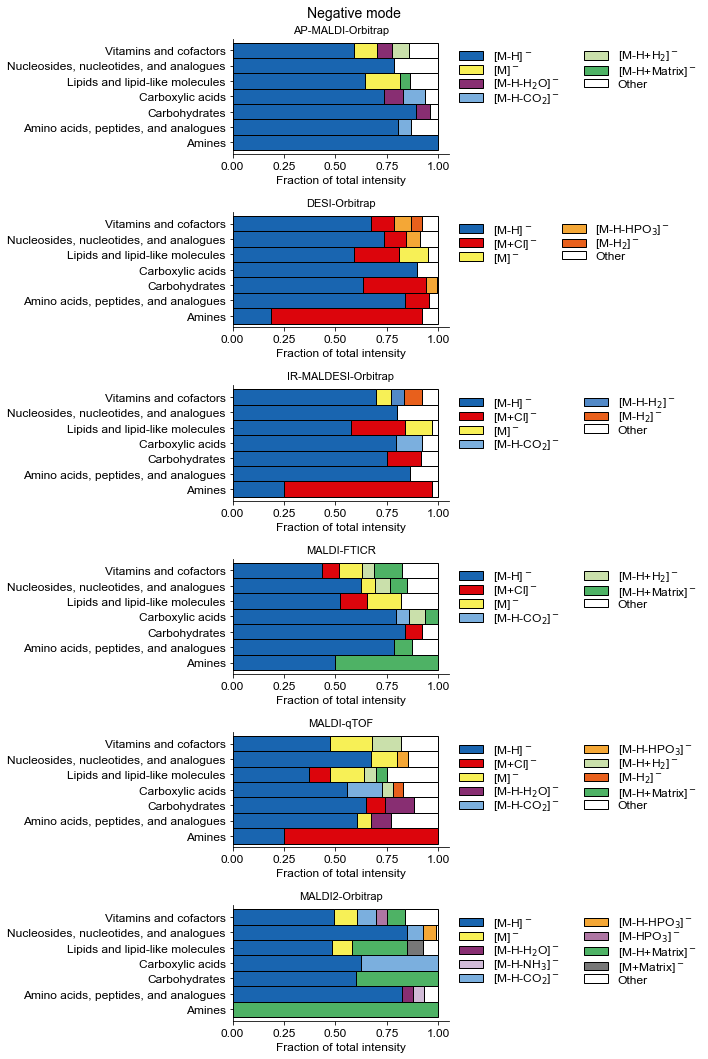

In [28]:
input_data = technology_data[technology_data.Polarity=="negative"]
title = "signal_dilution_per_techbnology_negative"

fig, axs = plt.subplots(nrows=6, ncols=1, sharey=True, figsize=(10,15))

for ax, technology in zip(axs.ravel(), input_data.Technology.unique()):
    subset = input_data[input_data.Technology == technology]
    
    # Prepeare data for plotting
    plot_data = prepare_data_for_plotting(subset, custom_col_order)    
    custom_palette = [color_dict.get(x) for x in plot_data.columns]

    # Make a plot
    plot_data.plot(kind="barh", rot=0, stacked=True, color=custom_palette, ax=ax, edgecolor='k', width=1)
#     ax.invert_yaxis()
    ax.set_title(technology, fontsize=11)
    ax.set_xlabel('Fraction of total intensity')
    ax.set_ylabel('')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Legend appearance
    ax.legend(loc="upper left", bbox_to_anchor=(1,1), frameon=False, ncol=2, labelspacing=0)  
    
fig.suptitle('Negative mode', fontsize=14)
fig.tight_layout()
fig.savefig(p_out / f"{title}.png")
fig.savefig(p_out / f"{title}.pdf", transparent=True)